# Distributed Computation
*Blaine Rogers &lt;<br1314@ic.ac.uk>&gt; 26-09-2016*

This notebook explores using the TensorFlow distributed runtime with the classes in `gptf.distributed` to distribute computation across a cluster. We'll start by generating a full gp to test against, a template expert and some data.

In [1]:
import datetime
import gptf
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

full_gp = gptf.gpr.GPR(gptf.kernels.RBF(variance=10.), noise_variance=.5)

def new_expert():
    return gptf.gpr.GPR(
        gptf.kernels.RBF(variance=10.),
        noise_variance=.5
    )

X = np.random.uniform(0., 10., (20, 1))
Y = full_gp.compute_prior_samples(X, 1, 1)[0]
Y += np.random.normal(0., np.sqrt(full_gp.likelihood.variance.value), Y.shape)

test_points = np.linspace(-5, 10, 100).reshape(-1, 1)

## Constructing the rBCM as a tree

As can be seen in section 4 of [Deisenroth & Ng (2015)][deisenroth15], an rBCM can be constructed as a computational graph, with GP experts at the leaves, a layer of gPoE models, then arbitrarily many layers of PoE models, followed by a prior correction at the root.

[deisenroth15]: http://jmlr.org/proceedings/papers/v37/deisenroth15.pdf

In [2]:
experts = [new_expert()] * 10

rbcm = gptf.distributed.rBCMReduction(
    experts, gptf.distributed.cao_fleet_weights
)

In [3]:
# create a 2, 5 hierachy
#            prior correction
#                  |
#                 PoE
#           /              \
#        gPoE             gPoE
#   /  /  |  |  \    /  |  |  \  \
#  E  E   E  E   E  E   E  E   E  E

# create gPoE layer
weights = gptf.distributed.cao_fleet_weights
layer = [gptf.distributed.gPoEReduction(experts[i:i+5], weights)
         for i in range(0, len(experts), 5)]

# create PoE layer
root = gptf.distributed.PoEReduction(layer)

# add prior correction
def total_weight(_, X, Y, points):
    w = weights(experts, X, Y, points)
    return [tf.reduce_sum(tf.pack(w, 0), 0)]
tree_rbcm = gptf.distributed.PriorDivisorReduction(root, total_weight)

Below, we check the posterior mean and variance of our two rBCMs to ensure that they are the same.

Means are approx. equal: True
Variances are approx. equal: True


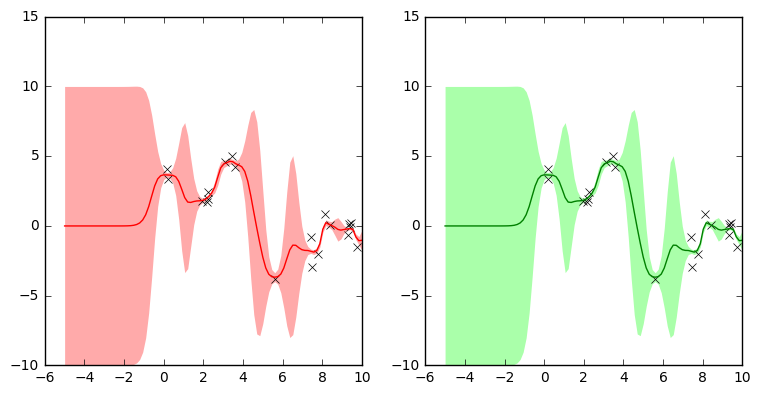

In [4]:
mean_a, var_a = rbcm.compute_posterior_mean_var(X, Y, test_points)
mean_b, var_b = tree_rbcm.compute_posterior_mean_var(X, Y, test_points)

print("Means are approx. equal: {}".format(np.allclose(mean_a, mean_b)))
print("Variances are approx. equal: {}".format(np.allclose(var_a, var_b)))

plt.figure(figsize=(9, 4.5))
axes = plt.subplot(121)
plt.plot(X, Y, 'kx',
         test_points, mean_a, 'r-')
plt.fill_between(test_points[:,0],
                 (mean_a + var_a)[:,0],
                 (mean_a - var_a)[:,0],
                 color='#ffaaaa', linewidth=0.)
plt.subplot(122, sharey=axes)
plt.plot(X, Y, 'kx',
         test_points, mean_b, 'g-')
plt.fill_between(test_points[:,0],
                 (mean_a + var_a)[:,0],
                 (mean_a - var_a)[:,0],
                 color='#aaffaa', linewidth=0.)
plt.show()

`gptf.distributed.tree_rBCM` does this construction for you, given a list of branching factors. For instance, 

```python
gptf.distributed.tree_rBCM(expert, weights, [3, 4, 5])
```

would create an rBCM with a prior divisor node at the root, whose child is a PoE node with three PoE children, each of which has four gPoE children with weightfunction `weights`, each of which has five children that are copies of `expert`.

In [5]:
tree_rbcm0 = gptf.distributed.tree_rBCM(
    experts, gptf.distributed.cao_fleet_weights, [2, 5]
)

mean_c, var_c = tree_rbcm0.compute_posterior_mean_var(X, Y, test_points)

print("Means are approx. equal: {}".format(np.allclose(mean_a, mean_c)))
print("Variances are approx. equal: {}".format(np.allclose(var_a, var_c)))

del tree_rbcm0

Means are approx. equal: True
Variances are approx. equal: True


## Distributing computation

Once the rBCM is constructed as a tree, `gptf` makes it easy to distribute the computations using TensorFlow's distributed runtime. One need only set the `.tf_device` attribute of a model to move its computation between devices.

In [6]:
cluster =\
    { 'worker':
        [ 'localhost:2222'
        , 'localhost:2223'
        ]
    , 'ps': 
        [ 'localhost:2224' ]
    , 'master': 
        [ 'localhost:2225']
    }
    
clusterspec = tf.train.ClusterSpec(cluster)

# start the servers
worker0 = tf.train.Server(clusterspec, 'worker', 0)
worker1 = tf.train.Server(clusterspec, 'worker', 1)
ps = tf.train.Server(clusterspec, 'ps', 0)
master = tf.train.Server(clusterspec, 'master', 0)

In [7]:
# place ops in a new graph so tensorflow doesn't complain
tree_rbcm.tf_graph = tf.Graph()
# set the session target for the root
tree_rbcm.tf_session_target = master.target

# set the tf_device of the first PoE node
tree_rbcm.child[0].tf_device = tf.DeviceSpec(job='worker', task=0)
# set the tf_device of the second PoE node
tree_rbcm.child[1].tf_device = tf.DeviceSpec(job='worker', task=1)
# set the tf_device of the params
for p in tree_rbcm.params:
    p.tf_device = tf.DeviceSpec(job='ps', task='0')

# params are placed on the parameter server
print(repr(tree_rbcm.child[0][0].kernel.variance.tensor.device))
print(repr(tree_rbcm.child[1][0].kernel.variance.tensor.device))
# hard computations are placed on the appropriate worker
print(repr(tree_rbcm.child[0][0].kernel.K(X).device))
print(repr(tree_rbcm.child[1][0].kernel.K(X).device))

'/job:ps/task:0'
'/job:ps/task:0'
'/job:worker/task:0'
'/job:worker/task:1'


Once the ops are appropriately pinned and the `.tf_session_target` of the root is properly set, computations will be automatically distributed across the cluster.

In [8]:
# distributed computation!
mean_d, var_d = tree_rbcm.compute_posterior_mean_var(X, Y, test_points)

print("Means are approx. equal: {}".format(np.allclose(mean_a, mean_d)))
print("Variances are approx. equal: {}".format(np.allclose(var_a, var_d)))

Means are approx. equal: True
Variances are approx. equal: True


`gptf.distributed.distrbuted_tree_rBCM` constructs the tree rBCM and applies the appropriate device pinnings for you. This makes it remarkably easy to start experimenting with distributed rBCMs!

In [9]:
tree_rbcm1 = gptf.distributed.distributed_tree_rBCM(
    experts, gptf.distributed.cao_fleet_weights, 
    clusterspec, target_job='master'
)

print(repr(tree_rbcm1.tf_session_target))
print(repr(tree_rbcm1.tf_graph))
print(repr(tree_rbcm1.child[0][0].kernel.K(X).device))
print(repr(tree_rbcm1.child[1][0].kernel.K(X).device))
print(repr(tree_rbcm1.params[0].tensor.device))

'grpc://localhost:2225'
'/job:worker/task:0'
'/job:worker/task:1'
'/job:ps/task:0'
